# Clean and reformat Xview dataset into YOLO format for YOLOv5 or YOLOv7

## Introduction
This is intended to be a stand-alone notebook to clean, and then re-format the Xview Dataset to the required sizes and data structures to implement YOLOv5 or any other repos based on that format.

The data is from WorldView-3 satellites, It has a consistent ground sample distance of 0.3 m.  This is both higher, and more uniform than most other datasets available. Also it covered a diverse geographic area, including many less developed and less urban locations.  I have explored the dataset further in my EDA notebook.

Dataset from [here](http://xviewdataset.org/) [Paper here](https://arxiv.org/pdf/1802.07856.pdf), and a description of the dataset format [here](https://challenge.xviewdataset.org/data-format). Only 60% of the dataset is provided.  The competition organisers held back 20% for leaderboard, and 20% for private test set and they have never been released so far as I'm aware.  I was mainly interested in the vehicle categories, but I pre-trained a YOLO model on all categories to improve generalisation.

I used the included geoExplore_environment.yml for data exploration.  Usage: `conda env create -f geoExplore_environment.yml`

In [25]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
from os import sep
import shutil
import json
import yaml
import matplotlib.pyplot as plt
import random

### Setup
- Put the data in a folder named 'Data', next to a folder containing this (and other) python scripts.
- Label the original data folders containing the large tif files /X_view/train_images, or change the file-paths to suit

In [26]:
LABELS_CSV_NM = 'X_view' + sep +  'train_labels' + sep + 'xView_train_csv.csv'
CLASS_MAP_CSV_NM = 'X_view' + sep + 'xView_class_map.csv'
LABELS_XML_NM = 'X_view' + sep + 'train_labels' + sep + 'xView_train.geojson'
DATA_FLDR_NM = 'Data'
IMAGE_FLDR_NM = 'X_view' + sep + 'train_images'
YOLO_DATA_FLDR = 'YOLO_images'
YOLO_CFG_FLDR = 'YOLO_cfg'
YAML_NM = 'xview_yolo.yaml'
CHUNK_WIDTH = 640  # size of the training images being created
CHUNK_HEIGHT = 640
MIN_CHUNK_HEIGHT = 320 # no training images will be kept if smaller than this
MIN_CHUNK_WIDTH = 320
IMAGE_WRITING = True # Set True to recreate the cropped training images
TEST_FRACTION = 0.1
VAL_FRACTION = 0.1
RANDOM_SEED = 27

project_directory = Path.cwd().parent
labels_csv_pth = project_directory / DATA_FLDR_NM / LABELS_CSV_NM
class_map_pth = project_directory / DATA_FLDR_NM / CLASS_MAP_CSV_NM
image_fldr = project_directory / DATA_FLDR_NM / IMAGE_FLDR_NM
out_fldr = project_directory / DATA_FLDR_NM / YOLO_DATA_FLDR
cfg_fldr = project_directory / DATA_FLDR_NM / YOLO_CFG_FLDR
labels_json_pth = project_directory / DATA_FLDR_NM / LABELS_XML_NM
yml_out = cfg_fldr / YAML_NM

def make_empty_dir(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)

for fldr in [out_fldr, cfg_fldr]:
    make_empty_dir(fldr)

random.seed(RANDOM_SEED)

## Data Extraction and Cleaning

In [27]:
with open(labels_json_pth, 'r') as infile:
    data = json.load(infile)
    keys = list(data.keys())

feature_list = data['features']
COLUMNS = ['IMAGE_ID', 'TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX', 'LONG', 'LAT']

data = []
for feature in feature_list:
    properties = feature['properties'] # a dict
    img_id = properties['image_id']  # '389.tif'
    type_id = properties['type_id']
    bbox = properties['bounds_imcoords'].split(",")  # eg '1917,38,1958,64'
    geometry = feature ['geometry']
    coords = geometry['coordinates'][0] #for some reason it's a list of lists
    long = coords[0][0] / 2  + coords[2][0] / 2
    lat = coords[0][1] / 2  + coords[1][1] / 2
    one_row = [img_id, type_id, bbox[0], bbox[1], bbox[2], bbox[3], long, lat]
    data.append(one_row)

instances = len(data)
instances

601937

In [28]:
df = pd.DataFrame(data, columns = COLUMNS)
df[['XMIN', 'YMIN', 'XMAX', 'YMAX']] = df[['XMIN', 'YMIN', 'XMAX', 'YMAX']].apply(pd.to_numeric)
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


In [29]:
df = df[(df.TYPE_ID != 75) & (df.TYPE_ID != 82)]   # removing erroneous labels
print(f'{instances - len(df)} rows removed, leaving {len(df)} rows')

79 rows removed, leaving 601858 rows


In [30]:
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Remove anything from image 1395, this image does not exist in the dataset

In [31]:
old_length = len(df)
df = df[df.IMAGE_ID != '1395.tif']
print(f'{old_length - len(df)} rows removed, leaving {len(df)}')

131 rows removed, leaving 601727


In [32]:
df.head()   #something is a bit off here.

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Also it's useful to convert the type IDs into a continuous sequence from 0 to 59 for the 60 categories.  The original competition labels were not arranged this way. The dictionary below is the original mapping from the competition website.

In [33]:
old_dict = {
    11:'Fixed-wing Aircraft', 12:'Small Aircraft', 13:'Passenger/Cargo Plane', 15:'Helicopter',
    17:'Passenger Vehicle', 18:'Small Car', 19:'Bus', 20:'Pickup Truck', 21:'Utility Truck',
    23:'Truck', 24:'Cargo Truck', 25:'Truck Tractor w/ Box Trailer', 26:'Truck Tractor',27:'Trailer',
    28:'Truck Tractor w/ Flatbed Trailer', 29:'Truck Tractor w/ Liquid Tank', 32:'Crane Truck',
    33:'Railway Vehicle', 34:'Passenger Car', 35:'Cargo/Container Car', 36:'Flat Car', 37:'Tank car',
    38:'Locomotive', 40:'Maritime Vessel', 41:'Motorboat', 42:'Sailboat', 44:'Tugboat', 45:'Barge',
    47:'Fishing Vessel', 49:'Ferry', 50:'Yacht', 51:'Container Ship', 52:'Oil Tanker',
    53:'Engineering Vehicle', 54:'Tower crane', 55:'Container Crane', 56:'Reach Stacker',
    57:'Straddle Carrier', 59:'Mobile Crane', 60:'Dump Truck', 61:'Haul Truck', 62:'Scraper/Tractor',
    63:'Front loader/Bulldozer', 64:'Excavator', 65:'Cement Mixer', 66:'Ground Grader', 71:'Hut/Tent',
    72:'Shed', 73:'Building', 74:'Aircraft Hangar', 76:'Damaged Building', 77:'Facility', 79:'Construction Site',
    83:'Vehicle Lot', 84:'Helipad', 86:'Storage Tank', 89:'Shipping container lot', 91:'Shipping Container',
    93:'Pylon', 94:'Tower'}

Making a new mapping from 0 to 59

In [34]:
old_keys = sorted(list(old_dict.keys()))
new_dict = {old_dict[x]:y for y, x in enumerate(old_keys)}
class_map_dict = {y:old_dict[x] for y, x in enumerate(old_keys)}
print(class_map_dict)

{0: 'Fixed-wing Aircraft', 1: 'Small Aircraft', 2: 'Passenger/Cargo Plane', 3: 'Helicopter', 4: 'Passenger Vehicle', 5: 'Small Car', 6: 'Bus', 7: 'Pickup Truck', 8: 'Utility Truck', 9: 'Truck', 10: 'Cargo Truck', 11: 'Truck Tractor w/ Box Trailer', 12: 'Truck Tractor', 13: 'Trailer', 14: 'Truck Tractor w/ Flatbed Trailer', 15: 'Truck Tractor w/ Liquid Tank', 16: 'Crane Truck', 17: 'Railway Vehicle', 18: 'Passenger Car', 19: 'Cargo/Container Car', 20: 'Flat Car', 21: 'Tank car', 22: 'Locomotive', 23: 'Maritime Vessel', 24: 'Motorboat', 25: 'Sailboat', 26: 'Tugboat', 27: 'Barge', 28: 'Fishing Vessel', 29: 'Ferry', 30: 'Yacht', 31: 'Container Ship', 32: 'Oil Tanker', 33: 'Engineering Vehicle', 34: 'Tower crane', 35: 'Container Crane', 36: 'Reach Stacker', 37: 'Straddle Carrier', 38: 'Mobile Crane', 39: 'Dump Truck', 40: 'Haul Truck', 41: 'Scraper/Tractor', 42: 'Front loader/Bulldozer', 43: 'Excavator', 44: 'Cement Mixer', 45: 'Ground Grader', 46: 'Hut/Tent', 47: 'Shed', 48: 'Building', 49

Now we can convert the dataframe's old TYPE_IDs to their new values

In [35]:
df['TYPE_ID'] = df['TYPE_ID'].apply(lambda x: new_dict[old_dict[x]])
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,48,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,48,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,48,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,48,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,48,2671,838,2714,869,-90.531766,14.567149


## Helper Functions

In [36]:
def get_boxes(in_df, class_lst=[]):
    if class_lst:
        in_df = in_df[in_df['TYPE_ID'].isin(class_lst)]
    unique_images = in_df.IMAGE_ID.unique().tolist()
    boxs = {}

    for image in unique_images:
        mask = in_df['IMAGE_ID'] == image
        masked = in_df[mask][['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']]
        boxs[image] = masked.values.tolist()

    return boxs


def load_image(file_pth): #for display
        image_obj = cv2.imread(file_pth)
        image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)
        return image_obj


def load_bgr_image(file_pth): # for processing only, no need to visualise the image
        image_obj = cv2.imread(file_pth)
        return image_obj

'''The colors are coming out a bit odd intermittently.  I haven't got to the bottom of why, but suspect it has
something to do with the pixel depth.  Shouldn't actually matter for the purpose of making the training dataset.
'''
def display_images(image_lst, boxes_dictionary, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = str(image_fldr / img_nm)
        img = load_image(image_path)

        # create a bounding box with the data & draw it
        if img_nm in boxes_dictionary:
            for box in boxes_dictionary[img_nm]:
                box_id, x_min, y_min, x_max, y_max = box
                x_min, y_min, x_max, y_max = int(x_min), int(y_max), int(x_max), int(y_min)
                # (left top), (right, bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[box_id]
                    else:
                        box_label = str(box_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()


#Convert YOLO to CV2 rectangle (l,t),(r,b)
def get_corners(x_cen, y_cen, an_width, an_height, im_width, im_height):
    x_cen, y_cen, an_width, an_height = float(x_cen), float(y_cen), float(an_width), float(an_height)
    left = (x_cen - an_width/2)*im_width
    top = (y_cen - an_height/2)*im_height
    right = (x_cen + an_width/2)*im_width
    bottom = (y_cen + an_height/2)*im_height
    return int(left), int(top), int(right), int(bottom)


def display_yolo_images(image_lst, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    _, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = out_fldr / img_nm
        text_fn = image_path.stem + '.txt'
        boxes_path = out_fldr / text_fn
        img = load_image(str(image_path))
        im_h, im_w, _ = img.shape
        with open(boxes_path) as text_file:
            annotations = [line.rstrip().split() for line in text_file]

        # create a bounding box with the data & draw it
        for ann in annotations:
                class_id = ann[0]
                x_centre, y_centre, w, h = ann[1], ann[2], ann[3], ann[4]
                x_min, y_min, x_max, y_max = get_corners(x_centre, y_centre, w, h, im_w, im_h)
                # (left top), (right bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[int(class_id)]
                    else:
                        box_label = str(class_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()


# For a given square within a chunk of a larger image, find any boxes in it
# Return the boxes in YOLO format relative to the chunk boundary
def match_boxes(box_list, chnk_lims):
    boxes_lists = []
    le, to = chnk_lims[0], chnk_lims[1]  # chunk_limits = [c, r, chunk_w, chunk_h]
    w, h  = chnk_lims[2], chnk_lims[3]
    for box in box_list:
        o_left, o_top, o_right, o_bottom = box[1], box[2], box[3], box[4]
        left, right = (o_left - le)/w, (o_right - le)/w  # translate and normalise
        top, bottom = (o_top - to)/h, (o_bottom - to)/h

        h_match = (0 <= left < 1) or (0 < right <= 1)
        v_match = (0 <= top < 1) or (0 < bottom <= 1)

        if v_match and h_match:
            clipped = np.clip([left, top, right, bottom], a_min=0, a_max=1)
            l, t, r, b = clipped[0], clipped[1], clipped[2], clipped[3]
            bounding_box = [str(box[0]),
                            str(round((l + r)/2, 5)),
                            str(round((t + b)/2, 5)),
                            str(round(r-l, 5)),
                            str(round(b-t, 5))]
            boxes_lists.append(bounding_box)
    return boxes_lists

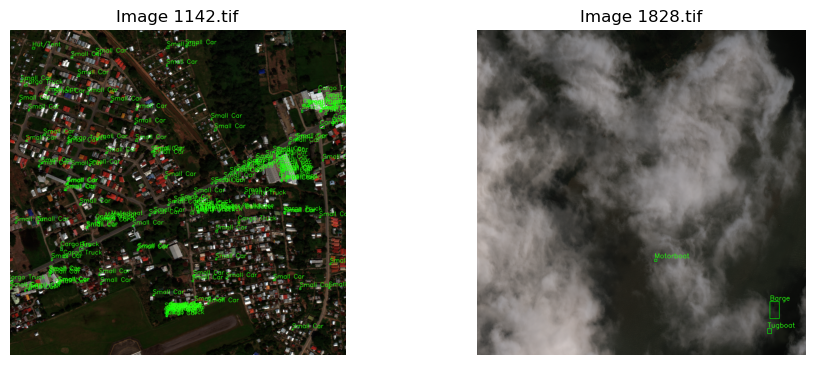

In [37]:
all_classes = list(class_map_dict.keys())
transport_only = [x for x in all_classes if x < 48]
boxes = get_boxes(df, transport_only)
images_for_display = random.choices(list(boxes.keys()), k=2)
display_images(images_for_display, boxes, 2, 2, True, class_map_dict) #adjust as desired

Writing a Function to iterate through each box, and check if it fits in the limits of an image chunk. If yes, return the label in YOLO format
[BBOX format details](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) expected for YOLO:  class, x_center, y_center, width, height
All values normalised to fraction of image width and height pixel values in a text file `image_file_name.txt`

## Main Process
- Break up the large tif files into chunks
- Save those chunks as jpg files
- check if any chunks contain annotations
- re-format those annotations into YOLO format
- Write all annotations in YOLO format to a dictionary with the filename as a key

In [38]:
img_fns = df.IMAGE_ID.unique().tolist()
yolo_df = pd.DataFrame(columns=['LEFT','TOP','RIGHT','BOTTOM'])
boxes_dict = get_boxes(df) # returns a dict of the form {filename:[['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']..]}
yolo_boxes= {}

for img_fn in img_fns:
    labels_list = boxes_dict[img_fn]
    #chunks_dict = {}
    img_pth = str(image_fldr / img_fn)
    im = load_bgr_image(img_pth)
    full_h, full_w, _ = im.shape

    for r in range(0, full_h, CHUNK_HEIGHT):
        for c in range(0, full_w, CHUNK_WIDTH):
            stem = img_fn.split('.')[0]
            fn = str(f"img_{stem}_{r}_{c}.jpg")
            out_pth = str(out_fldr / fn)

            chunk_h = CHUNK_HEIGHT
            chunk_w = CHUNK_WIDTH

            if r + CHUNK_HEIGHT > full_h:
                chunk_h = full_h - r
            if c + CHUNK_WIDTH > full_w:
                chunk_w = full_w - c
            big_enough = (chunk_h > MIN_CHUNK_HEIGHT) and (chunk_w > MIN_CHUNK_WIDTH)

            if big_enough:
                if IMAGE_WRITING:
                    cv2.imwrite(out_pth, im[r:r+chunk_h, c:c+chunk_w,:])
                # Find any boxes occurring in the chunk, and convert to YOLO format
                chunk_limits = [c, r, chunk_w, chunk_h]
                yolo_boxes[fn] = match_boxes(labels_list, chunk_limits)

## Write the new YOLO formatted text files
Iterate through the dictionary, creating a text file for each image:  class x y width height, then save the completed text file to the same location, with the same stem name as the image.

In [39]:
for image_fn in os.listdir(out_fldr):
    stem = image_fn.split('.')[0]
    fn = str (stem) + '.txt'
    txt_pth = str(out_fldr / fn)
    seperator = ' '
    with open(txt_pth, 'a') as f:
        if image_fn in yolo_boxes:
            for bbox in yolo_boxes[image_fn]:
                txt = seperator.join(bbox) + '\n'
                f.write(txt)

## Display some random images to validate the result

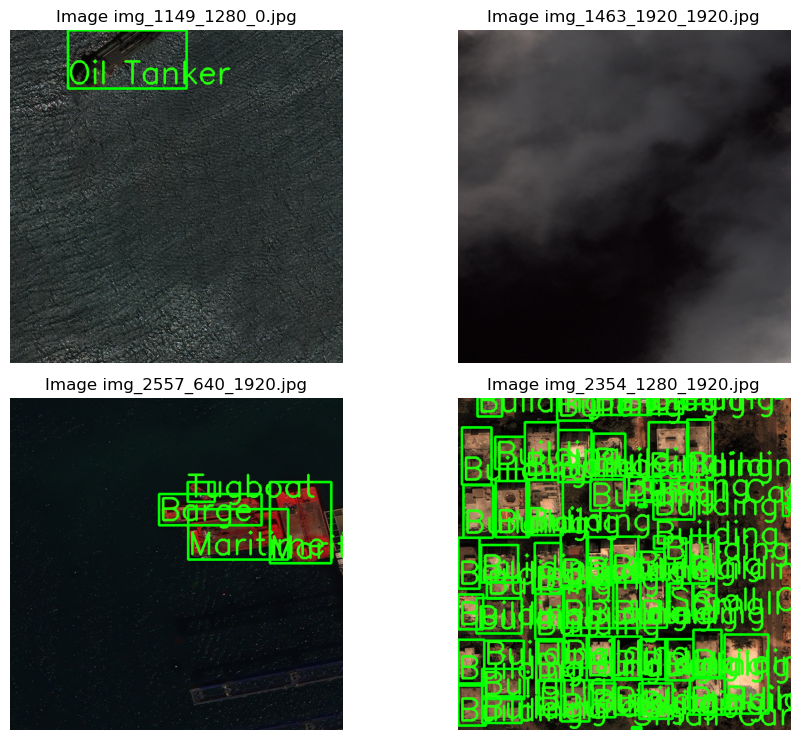

In [40]:
filenames = [x for x in os.listdir(out_fldr) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, max_images=4, no_cols=2, text=True,  class_map=class_map_dict)

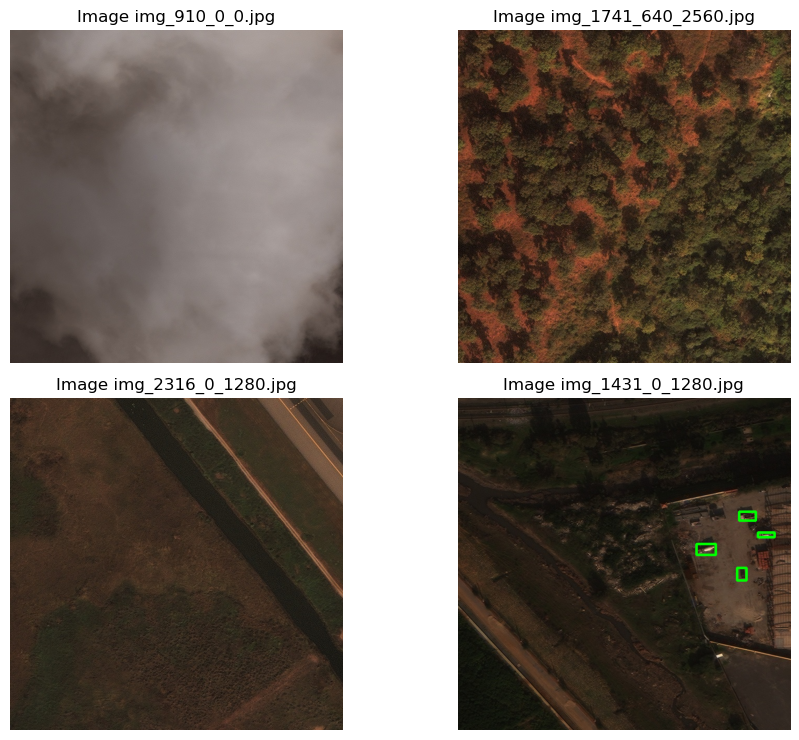

In [41]:
#without text labels
filenames = [x for x in os.listdir(out_fldr) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, max_images=4, no_cols=2, text=False)

## Do a train-test-val split

In [42]:
total_images = len(filenames)
indices = list(range(total_images))
random.shuffle(indices)

train_fraction = 1 - TEST_FRACTION - VAL_FRACTION
train_sp = int(np.floor(train_fraction * len(indices))) # The training-validation split
valid_sp = int(np.floor(VAL_FRACTION * len(indices))) + train_sp # The validation-test split
train_idx, val_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(val_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

 Training set size: 	 15856
 Validation set size: 	 1982
 Test set size: 	 1982
 Total dataset: 	 19820


Write 3 text files into the Data folder with the file paths
train.txt
val.txt
test.txt

These are lists of filepaths, one line each path.  They can reside anywhere, so put under /Data/YOLO_cfg

In [43]:
files = ['train.txt', 'val.txt', 'test.txt']
splits = [train_idx, val_idx, test_idx]

for fn, split in zip(files, splits):
    txt_pth = cfg_fldr / fn
    with open(txt_pth, 'a') as f:
        for ind in split:
            f.write(str(out_fldr / filenames[ind]) + '\n')

## Write a .yaml file
Write a .yaml file pointing to the text file locations, and determining class names, number of categories location.
This is good practice, it means I don't need to move all the image files around just to change the training splits.
Also the .yml file gets updated automatically if anybody changes something like the number of classes.

In [44]:
config = {'train': str(project_directory / cfg_fldr / files[0]),
          'val': str(project_directory / cfg_fldr / files[1]),
          'test': str((project_directory / cfg_fldr / files[2])),
          'nc': len(class_map_dict),
          'names': class_map_dict
          }

with open(yml_out, "w") as file:
    yaml.dump(config, file, default_style=None, default_flow_style=False, sort_keys=False)

print(yaml.dump(config, default_style=None, default_flow_style=False, sort_keys=False))

train: /media/olly/T7 Shield/Documents/Data Science/GFA_Vehicle_Detection/Data/YOLO_cfg/train.txt
val: /media/olly/T7 Shield/Documents/Data Science/GFA_Vehicle_Detection/Data/YOLO_cfg/val.txt
test: /media/olly/T7 Shield/Documents/Data Science/GFA_Vehicle_Detection/Data/YOLO_cfg/test.txt
nc: 60
names:
  0: Fixed-wing Aircraft
  1: Small Aircraft
  2: Passenger/Cargo Plane
  3: Helicopter
  4: Passenger Vehicle
  5: Small Car
  6: Bus
  7: Pickup Truck
  8: Utility Truck
  9: Truck
  10: Cargo Truck
  11: Truck Tractor w/ Box Trailer
  12: Truck Tractor
  13: Trailer
  14: Truck Tractor w/ Flatbed Trailer
  15: Truck Tractor w/ Liquid Tank
  16: Crane Truck
  17: Railway Vehicle
  18: Passenger Car
  19: Cargo/Container Car
  20: Flat Car
  21: Tank car
  22: Locomotive
  23: Maritime Vessel
  24: Motorboat
  25: Sailboat
  26: Tugboat
  27: Barge
  28: Fishing Vessel
  29: Ferry
  30: Yacht
  31: Container Ship
  32: Oil Tanker
  33: Engineering Vehicle
  34: Tower crane
  35: Container